### Example code for computing CIV distance.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
#import richardsplot as rplot
from sklearn.preprocessing import scale

from CIVfunctions import project, CIV_distance

---

#### Basic implementation

Load in example file with CIV EW+Blueshift already computed.

In [2]:
# %load CIVfunctions
import numpy as np
from sklearn.preprocessing import scale

def project(data, fit):
    #Use: Project scattered data (data) onto a line of best fit (fit)
    #Returns: 2-D array of (x,y) locations on the line of your orthogonal projection
    
    #data: 2-D (N by 2) array of your data in some x-y space
    #fit: 2-D (N by 2) array of coordinates along your line of best fit
    
    locs = [] #this will contain xy locations along the best-fit curve corresponding to each data point's orthogonal projection onto said curve - python list faster than numpy array
    
    #Loop through each data point and compare with locations along fit
    for scat in data: 
        r2 = (scat[0]-fit[:,0])**2 + (scat[1]-fit[:,1])**2      #dist^2 of scat from each point along fit
        delta = [fit[np.argmin(r2), 0], fit[np.argmin(r2), 1]]  #save point along fit where dist^2 was minimum
        locs.append(delta)  
        
    return np.array(locs)


def CIV_distance(data_original, fit_original, step=1):
    #fit: N-by-2 array containing coordinates of points along best fit line 
    #data: N-by-2 [[x,y]] array of data 
    #NOTE: This really just caters to this situation (assumes monotonically decreasing fit_original)
    
    #1) Scale all the data equally
    xscale = scale(np.concatenate((fit_original[:,0], data_original[:,0]))) #add ``good`` mask to lofar to remove "bad" reconstructions
    yscale = scale(np.concatenate((fit_original[:,1], data_original[:,1])))
    fit = np.array([xscale[0:len(fit_original)], yscale[0:len(fit_original)]]).T
    data = np.array([xscale[len(fit_original):len(fit_original)+len(data_original)], yscale[len(fit_original):len(fit_original)+len(data_original)]]).T
    
    #2) data is now each point's orthogonal projection onto fit
    data = project(data, fit) 
        
    darr = [] #list to fill with distances along best-fit line for each point

    #3) Loop through each data point- start at tip of line and sum dist traveled until passing data point
    for scat in data:
        d = 0 #start at beginning of the line
        for i in range(0, fit.shape[0]-step, step):
            xp, x = fit[i,0], fit[i+step,0]
            yp, y = fit[i,1], fit[i+step,1] 
            dp = d
            d += np.sqrt((x-xp)**2 + (y-yp)**2)
            if yp >= scat[1] >= y: #if we pass the projected y-coord, save the distance traveled
                darr.append((d+dp)/2) #save the average between dprevious and d
                break
                
    return np.array(darr)


In [3]:
dat = pd.read_csv("data/LOFAR_from8403colorselected_all388_CIV.csv")
dat.iloc[:,10:].head()

,SDSS_NAME_1a,RA_1a,DEC_1a,REDSHIFT,PLATE_1a,FIBER_1a,MJD_1a,TARGET_FLAG_TARGET,NSPECOBS,UNIFORM_TARGET,...,Separation_2,CIV_blue,CIV_EW,good,z_paul,SDSS_NAME_2,Separation_Amy,CIV_DIST_021721,Separation,CIV_DIST_041921
0,104446.00+521742.8,161.191681,52.295242,1.7513,1010,182,52649,3,1,1,...,0.015827,87.889379,37.666121,True,1.75054,104446.00+521742.8,0.015827,2.522933,0.002494,2.124091
1,104547.58+551853.8,161.448257,55.314972,1.8896,906,462,52368,1048578,1,1,...,0.008950,142.521789,44.743671,True,1.88758,104547.58+551853.8,0.008950,2.422896,0.003449,1.985659
2,104718.64+541917.8,161.827698,54.321629,1.8288,906,55,52368,3145739,1,1,...,0.013102,832.307354,49.698713,True,1.83249,104718.64+541917.8,0.013102,2.791469,0.005172,2.129244
3,104829.97+550819.0,162.124893,55.138630,2.0671,906,518,52368,1048578,1,1,...,0.012861,1798.550056,22.573777,True,2.07342,104829.97+550819.0,0.012861,3.848747,0.003931,3.199583
4,104852.00+530747.2,162.216675,53.129780,1.6792,1010,509,52649,1048578,1,1,...,0.007413,872.211364,51.004578,True,1.68111,104852.00+530747.2,0.007413,2.801772,0.002967,2.110882


In [4]:
ew   = dat[["CIV_EW"]].values.flatten()
logEW   = np.log10(ew)
blue = dat[["CIV_blue"]].values.flatten()

#Best-fit line -- this part could be improved
bestfit = np.load("data/bestfit.npy")

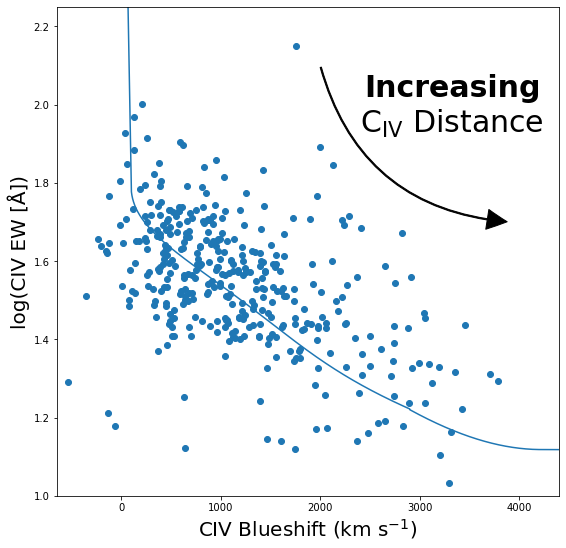

In [27]:
fig = plt.figure(figsize=(9,9))

#Visualize increasing CIV distance
style = "Simple, tail_width=1.25, head_width=20, head_length=20"
kw = dict(arrowstyle=style, color="k")
a1 = patches.FancyArrowPatch((2000, 2.1), (3900, 1.7),
                             connectionstyle="arc3,rad=.35", **kw)
plt.gca().add_patch(a1)
plt.text(x=2440,y=2.02,s="Increasing", fontsize=30, weight='extra bold')
plt.text(x=2400,y=1.93,s="C$_\mathrm{IV}$ Distance", fontsize=30)

plt.plot(bestfit[:,0], bestfit[:,1])
plt.scatter(blue, logEW)
plt.xlabel("CIV Blueshift (km s$^{-1}$)", fontsize=20)
plt.ylabel("log(CIV EW [Å])", fontsize=20)
plt.xlim(-650,4400)
plt.ylim(1,2.25)

plt.show()

Note: points beyond an endpoint of the curve will be projected onto the respective endpoint.

In [29]:
from time import time

start = time()
data = np.array([blue, logEW]).T
dist = CIV_distance(data, bestfit) #compute CIV distances like this
end = time()

---

#### Save time with the ``step`` parameter

``CIV_distance()`` function has an optional "step" parameter.  How it's normally set up is to project each data point onto the best-fit curve, then travel along the best-fit line--point-by-point--checking when you've passed a point on the line.  The default argument ``step=1`` will check every point along the curve, ``step=100`` will check every hundredth point etc.  Since the curve is so dense, you can often get away with a much higher step size than 1, decreasing your runtime dramatically (especially on bigger datasets); for example, ``step=100`` will result in 100 times less iterations of the for loop inside ``CIV_distance()``.

Visualize accuracy as a function of step size.  Will consider "correct" to be the distances corresponding to ``step=1``.

In [60]:
bestfit.shape

(52920, 2)

In [67]:
step_list = np.logspace(np.log10(1), np.log10(2000), 11).astype(int)
diff_list = [0]
dt_list   = [end - start]
step_list

array([   1,    2,    4,    9,   20,   44,   95,  204,  437,  935, 2000])

In [68]:
for step_size in step_list[1:]:
    start_time = time()
    idist = CIV_distance(data, bestfit, step=step_size)
    diff_list.append(np.median(np.abs((dist-idist)/dist)))
    end_time = time()
    dt_list.append(end_time - start_time)

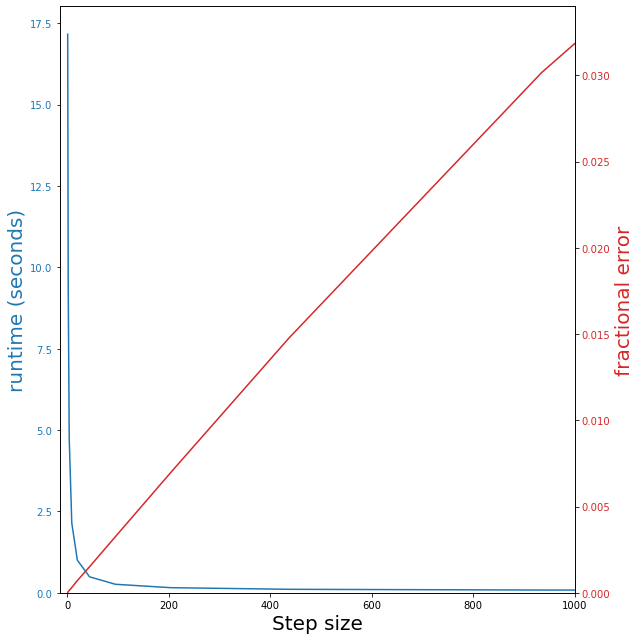

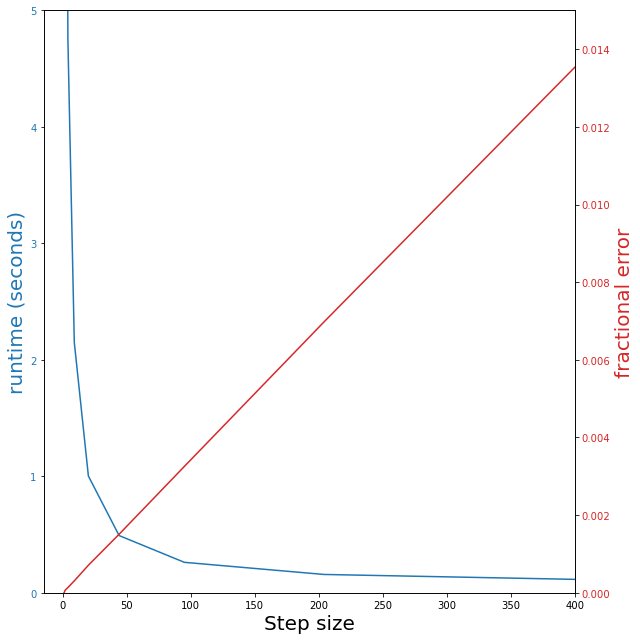

In [83]:
fig, ax1 = plt.subplots(figsize=(9,9))

color_frac = 'tab:red'
color_time = 'tab:blue'

ax1.set_xlabel('Step size', fontsize=20)
ax1.set_ylabel('runtime (seconds)', color=color_time, fontsize=20)
ax1.plot(step_list, dt_list, color=color_time)
ax1.tick_params(axis='y', labelcolor=color_time)
ax1.set_xlim(None, 1000)
ax1.set_ylim(0, None)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('fractional error', color=color_frac, fontsize=20)  # we already handled the x-label with ax1
ax2.plot(step_list, diff_list, color=color_frac)
ax2.tick_params(axis='y', labelcolor=color_frac)
ax2.set_xlim(-15, 1000)
ax2.set_ylim(0, .034)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

fig, ax11 = plt.subplots(figsize=(9,9))

ax11.set_xlabel('Step size', fontsize=20)
ax11.set_ylabel('runtime (seconds)', color=color_time, fontsize=20)
ax11.plot(step_list, dt_list, color=color_time)
ax11.tick_params(axis='y', labelcolor=color_time)
ax11.set_xlim(None, 400)
ax11.set_ylim(0,5)

ax22 = ax11.twinx()  # instantiate a second axes that shares the same x-axis

ax22.set_ylabel('fractional error', color=color_frac, fontsize=20)  # we already handled the x-label with ax1
ax22.plot(step_list, diff_list, color=color_frac)
ax22.tick_params(axis='y', labelcolor=color_frac)
ax22.set_xlim(-15, 400)
ax22.set_ylim(0, 0.015)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Plot showing both the time saved and median error in C IV distance as a function of step size.  Lesson learned: use a non-unity step size for lots of data! Roughly ``step=50-100`` looks like a good choice.  **Use the step parameter when testing big datasets.**